In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

2023-06-12 11:34:22.936900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dev = qml.device('default.mixed', wires=2)

In [3]:
def real():
    qml.Rot( 0.0,np.pi/2, np.pi/6,wires=0)

In [4]:
print(qml.draw(real)())

0: ──Rot(0.00,1.57,0.52)─┤  


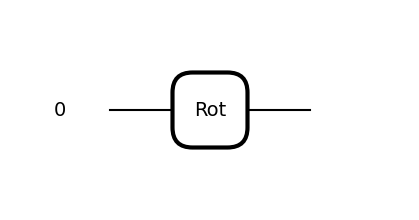

In [23]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(real)()
plt.show()

In [5]:
def generator(w,**kwargs):
    qml.RZ(w[0], wires=1)
    qml.RX(w[1], wires=1)
    qml.RZ(w[2], wires=1)
    qml.Rot(0.0, np.pi/2, -np.pi/6,wires=1)

In [6]:
print(qml.draw(generator)([ 0,0,0]))

1: ──RZ(0.00)──RX(0.00)──RZ(0.00)──Rot(0.00,1.57,-0.52)─┤  


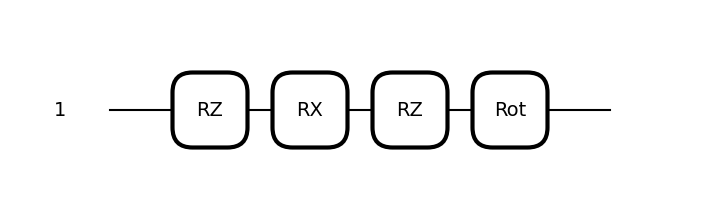

In [24]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(generator)([ 0,0,0])
plt.show()

In [7]:
def discriminator(w):
    qml.Hadamard(wires=1)
    qml.CZ(wires=[0, 1])
    qml.RZ(w[0], wires=0)
    qml.RZ(w[1], wires=1)
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

In [8]:
print(qml.draw(discriminator)([ 0,1]))

1: ──H─╭Z──RZ(1.00)──H─┤  
0: ────╰●──RZ(0.00)──H─┤  


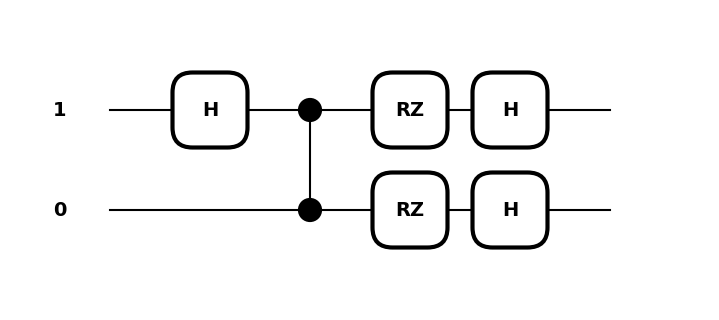

In [31]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(discriminator)([ 0,0])
plt.show()

In [9]:
@qml.qnode(dev, interface='tf')
def real_gen_disc_circuit(gen_weights, disc_weights):
    real()
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval((qml.Identity(0)-qml.PauliZ(0))@ (qml.Identity(1)-qml.PauliZ(1)))
#qml.expval(qml.PauliZ(0) @ qml.PauliX(2))


In [10]:
print(qml.draw(real_gen_disc_circuit)([ 0,0,0,0,0,0,0,0,0],[ 0,0]))

0: ──Rot(0.00,1.57,0.52)──────────────────────────────────────────────╭●──RZ(0.00)──H─┤ ╭<𝓗>
1: ──RZ(0.00)─────────────RX(0.00)──RZ(0.00)──Rot(0.00,1.57,-0.52)──H─╰Z──RZ(1.00)──H─┤ ╰<𝓗>


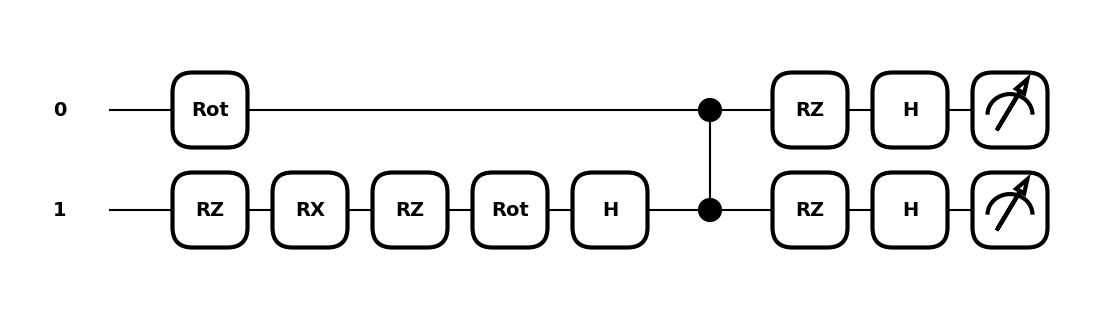

In [32]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(real_gen_disc_circuit)([ 0,0,0,0,0,0,0,0,0],[ 0,0])
plt.show()

In [11]:
def prob_discriminated(gen_weights,disc_weights):
    discriminated_output = real_gen_disc_circuit(gen_weights, disc_weights)
    #convert to probability
    prob_discriminated_output = (discriminated_output)/4
    return prob_discriminated_output

In [12]:
def disc_cost(disc_weights):
    cost = 1-prob_discriminated(gen_weights,disc_weights)
    return cost
def gen_cost(gen_weights):
    cost = prob_discriminated(gen_weights,disc_weights)
    return cost

In [13]:
@qml.qnode(dev, interface="tf")
def circuit_gs(angles):
    generator(angles)
    return qml.density_matrix([1])
@qml.qnode(dev, interface="tf")
def circuit_rs():
    real()
    return qml.density_matrix([0])

In [14]:
np.random.seed(0)
eps = 1e-2
#init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   #np.random.normal(scale=eps, size=(9,))
    
init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]
epochs = 10
for i in range(epochs):            
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.5)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step_d.append(step)
            print("Step {}: cost = {}".format(step, loss_val)) 
            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.5)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step_g.append(step)
            print("Step {}: cost = {}".format(step, loss_val))
            #red_r = qml.math.reduced_dm(circuit_rs(),indices=[0])
            #red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[1])
            #state_fidelity = qml.math.fidelity(red_r, red_g)
            state_fidelity = qml.math.fidelity(circuit_rs(), circuit_gs(var_g))
            sg.append(state_fidelity)
    

2023-06-12 11:34:35.187259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Step 0: cost = 0.850876542653979
Step 5: cost = 0.7025731729213578
Step 10: cost = 0.5792043324814009
Step 15: cost = 0.5239942739267823
Step 20: cost = 0.5065775901518432
Step 25: cost = 0.5017498181586421
Step 30: cost = 0.500461698526553
Step 35: cost = 0.5001215563921916
Step 40: cost = 0.5000319850848711
Step 45: cost = 0.5000084149492485
Step 0: cost = 0.4999963404652626
Step 5: cost = 0.499988116490076
Step 10: cost = 0.49996141226491453
Step 15: cost = 0.49987471259939514
Step 20: cost = 0.4995933556466044
Step 25: cost = 0.4986816427204264
Step 30: cost = 0.49574136914343947
Step 35: cost = 0.486403183848892
Step 40: cost = 0.45813928267302084
Step 45: cost = 0.3838623135279239
Step 0: cost = 0.6924071277960684
Step 5: cost = 0.5735199964366676
Step 10: cost = 0.5220363870987406
Step 15: cost = 0.5060203193623072
Step 20: cost = 0.5016000498319402
Step 25: cost = 0.5004220743662191
Step 30: cost = 0.500111116667247
Step 35: cost = 0.5000292375685785
Step 40: cost = 0.500007692

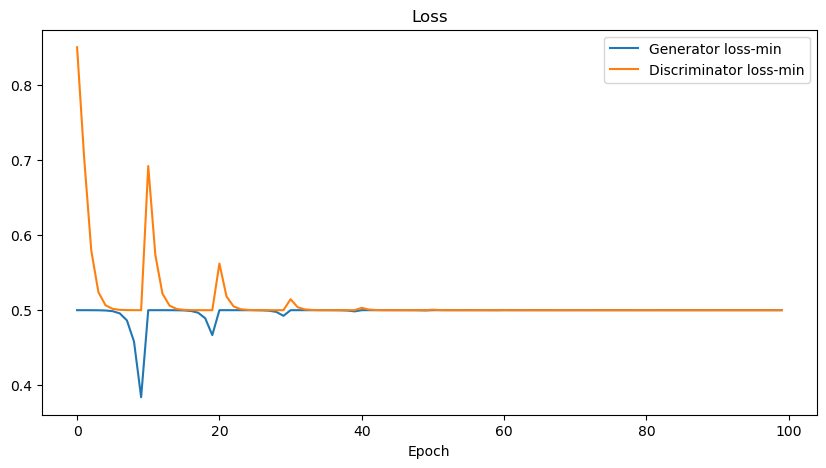

In [15]:
#loss_d = [ 1-x for x in loss_val_d]
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss-min")
plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

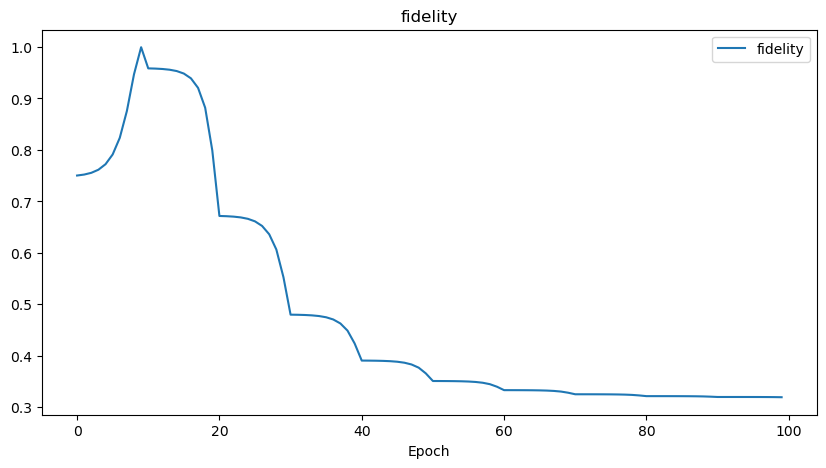

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), sg, label="fidelity")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [17]:
# perfect swap

np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))
    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

# train only generator while discriminator is a perfect swap frozen discriminator
loss_val_d = []
loss_val_g = []
#step_d = []
step_gf = []
sg_f =[]
epochs = 50
a = 1
for i in range(epochs): 
    #opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a)
            step_gf.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            #red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            #red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            #state_fidelity = qml.math.fidelity(red_r, red_g)
            state_fidelity = qml.math.fidelity(circuit_rs(), circuit_gs(var_g))
            sg_f.append(state_fidelity)
            
perfect_swap = sg_f
perfect_step_g = step_gf     
           

Step 0: cost = 0.10752363366410364
Step 1: cost = 0.09114488199901631
Step 2: cost = 0.07672865631153614
Step 3: cost = 0.06420061245388978
Step 4: cost = 0.05343464232191103
Step 5: cost = 0.04427226247092025
Step 6: cost = 0.03653924542282617
Step 7: cost = 0.030058588921064746
Step 8: cost = 0.02465973852403899
Step 9: cost = 0.02018448508119315
Step 10: cost = 0.01649019093750646
Step 11: cost = 0.013451038655918207
Step 12: cost = 0.010957925378718786
Step 13: cost = 0.00891750749468253
Step 14: cost = 0.007250774142497279
Step 15: cost = 0.005891415469629152
Step 16: cost = 0.004784160790942099
Step 17: cost = 0.0038831936681142376
Step 18: cost = 0.003150702651394985
Step 19: cost = 0.0025555939438173456
Step 20: cost = 0.0020723715511584487
Step 21: cost = 0.001680178143888357
Step 22: cost = 0.0013619831979912803
Step 23: cost = 0.001103902017800723
Step 24: cost = 0.0008946285739329929
Step 25: cost = 0.0007249657575316287
Step 26: cost = 0.0005874380291035763
Step 27: cost =

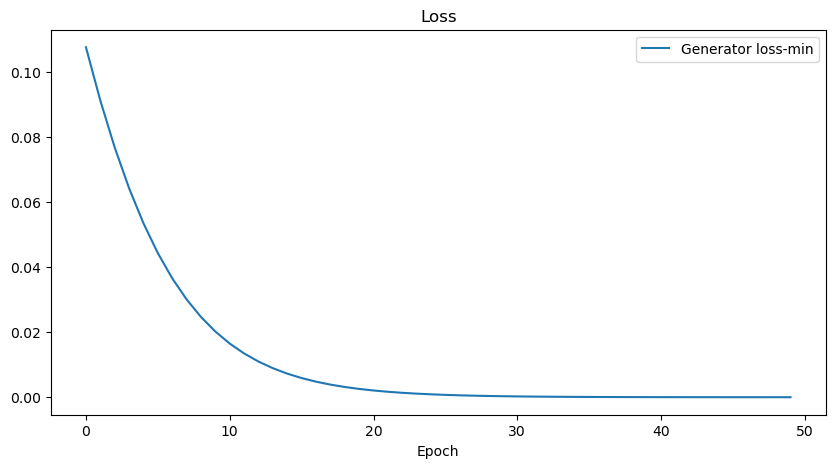

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_gf)), loss_val_g, label="Generator loss-min")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

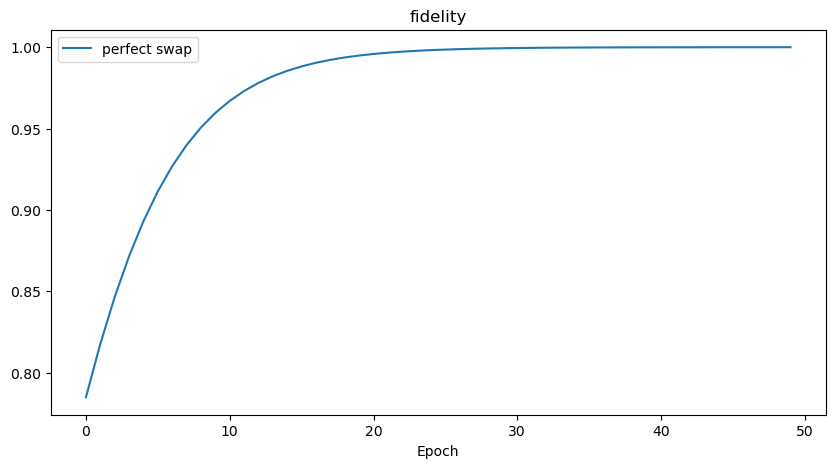

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(perfect_step_g)), perfect_swap, label="perfect swap")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [20]:
#  frozen discriminator + alternative training
#####
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)
#####

loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]

##
#fozen discriminator
epochs1 = 1
a1 = 50
for i in range(epochs1):            
    #opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a1):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a1)
            step_g.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            #red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            #red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            #state_fidelity = qml.math.fidelity(red_r, red_g)
            state_fidelity = qml.math.fidelity(circuit_rs(), circuit_gs(var_g))
            sg.append(state_fidelity)

#alternative training            
epochs2 = 50
a2 = 1
a3 = 1
for i in range(epochs2):
    #opt = tf.keras.optimizers.experimental.Adam(learning_rate=0.01)
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a2):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step2 = step+a1*epochs1+a2*i+a3*i
            step_d.append(step2)
            print("Step {}: cost = {}".format(step2, loss_val))  
            #red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            #red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            #state_fidelity = qml.math.fidelity(red_r, red_g)
            state_fidelity = qml.math.fidelity(circuit_rs(), circuit_gs(var_g))
            sg.append(state_fidelity) 
            
    #opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a3):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step3 = step+a1*epochs1+a2*(i+1)+a3*(i)
            step_g.append(step3)
            print("Step {}: cost = {}".format(step3, loss_val))
            #red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            #red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            #state_fidelity = qml.math.fidelity(red_r, red_g)
            state_fidelity = qml.math.fidelity(circuit_rs(), circuit_gs(var_g))
            sg.append(state_fidelity)

Step 0: cost = 0.10752363366410364
Step 5: cost = 0.04427226247092025
Step 10: cost = 0.01649019093750646
Step 15: cost = 0.005891415469629152
Step 20: cost = 0.0020723715511584487
Step 25: cost = 0.0007249657575316287
Step 30: cost = 0.0002531294828484465
Step 35: cost = 8.832955767363454e-05
Step 40: cost = 3.0818683828093274e-05
Step 45: cost = 1.0753536037411138e-05
Step 50: cost = 0.9999943974462662
Step 51: cost = 4.538844143371634e-06
Step 52: cost = 0.999994510230489
Step 53: cost = 4.4474104342884235e-06
Step 54: cost = 0.9999946206405337
Step 55: cost = 4.357907807617245e-06
Step 56: cost = 0.9999947287366286
Step 57: cost = 4.270286660806866e-06
Step 58: cost = 0.9999948345765086
Step 59: cost = 4.184499495102356e-06
Step 60: cost = 0.9999949382155927
Step 61: cost = 4.100500762299619e-06
Step 62: cost = 0.9999950397071469
Step 63: cost = 4.018246725495667e-06
Step 64: cost = 0.9999951391024318
Step 65: cost = 3.937695332578706e-06
Step 66: cost = 0.999995236450836
Step 67: 

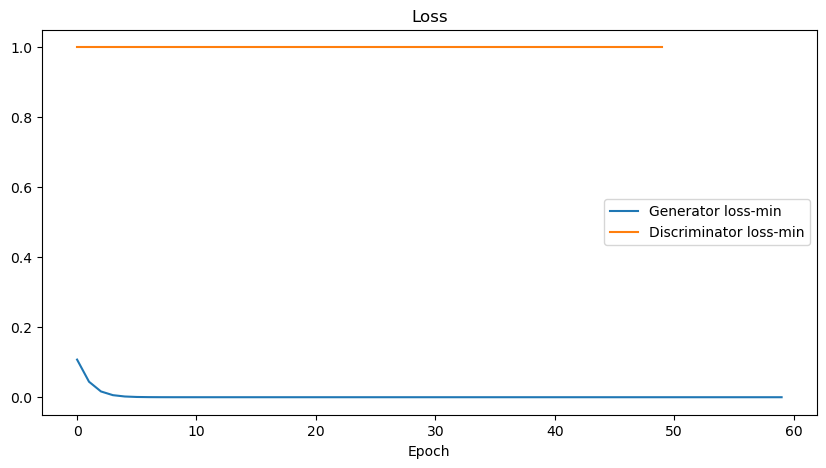

In [21]:
#loss_d = [ 1-x for x in loss_val_d]
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss-min")
plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

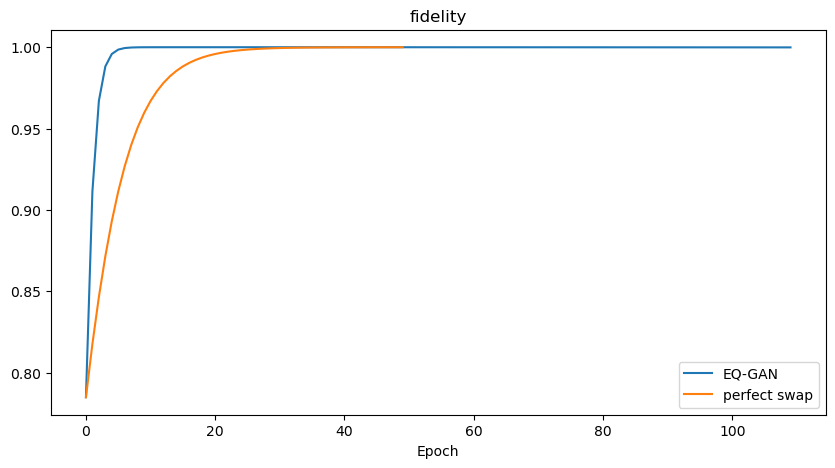

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g+step_d)), sg, label="EQ-GAN")
plt.plot(range(len(perfect_step_g)), perfect_swap, label="perfect swap")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()